In [ ]:
# https://github.com/Element84/geo-notebooks/blob/main/notebooks/planetary-computer-odc-stac-landsat.ipynb

In [ ]:
# pip install rich
# pip install dask-gateway==2025.4.0

In [18]:
import odc.stac
import planetary_computer
import dask.distributed

from pystac_client import Client
from rich.table import Table
from rich.markdown import Markdown
from folium import Map, GeoJson
from shapely.geometry import box
from dask_gateway import GatewayCluster

In [3]:
PLANETARY_COMPUTER = "https://planetarycomputer.microsoft.com/api/stac/v1"
client = Client.open(PLANETARY_COMPUTER)

In [4]:
collections = list(client.get_all_collections())

In [6]:
collections.sort(key=lambda c: c.id)
table = Table("ID", "Title", title="Planetary Computer collections")

for collection in collections:
    table.add_row(collection.id, collection.title)

table

                                          Planetary Computer collections                                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID                                                     ┃ Title                                                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 3dep-lidar-classification                              │ USGS 3DEP Lidar Classification                         │
│ 3dep-lidar-copc                                        │ USGS 3DEP Lidar Point Cloud                            │
│ 3dep-lidar-dsm                                         │ USGS 3DEP Lidar Digital Surface Model                  │
│ 3dep-lidar-dtm                                         │ USGS 3DEP Lidar Digital Terrain Model                  │
│ 3dep-lidar-dtm-native                                  │ USGS 3DEP Lidar Digital Terrain Model (Native)         │
│ 3dep-lidar-hag                                         │ USGS 3DEP Lidar Height above Ground                    │
│ 3dep-lidar-intensity                                   │ USGS 3DEP Lidar Intensity                              │
│ 3dep-lidar-pointsourceid                               │ USGS 3DEP Lidar Point Source                           │
│ 3dep-lidar-returns                                     │ USGS 3DEP Lidar Returns                                │
│ 3dep-seamless                                          │ USGS 3DEP Seamless DEMs                                │
│ alos-dem                                               │ ALOS World 3D-30m                                      │
│ alos-fnf-mosaic                                        │ ALOS Forest/Non-Forest Annual Mosaic                   │
│ alos-palsar-mosaic                                     │ ALOS PALSAR Annual Mosaic                              │
│ aster-l1t                                              │ ASTER L1T                                              │
│ chesapeake-lc-13                                       │ Chesapeake Land Cover (13-class)                       │
│ chesapeake-lc-7                                        │ Chesapeake Land Cover (7-class)                        │
│ chesapeake-lu                                          │ Chesapeake Land Use                                    │
│ chloris-biomass                                        │ Chloris Biomass                                        │
│ cil-gdpcir-cc-by                                       │ CIL Global Downscaled Projections for Climate Impacts  │
│                                                        │ Research (CC-BY-4.0)                                   │
│ cil-gdpcir-cc-by-sa                                    │ CIL Global Downscaled Projections for Climate Impacts  │
│                                                        │ Research (CC-BY-SA-4.0)                                │
│ cil-gdpcir-cc0                                         │ CIL Global Downscaled Projections for Climate Impacts  │
│                                                        │ Research (CC0-1.0)                                     │
│ conus404                                               │ CONUS404                                               │
│ cop-dem-glo-30                                         │ Copernicus DEM GLO-30                                  │
│ cop-dem-glo-90                                         │ Copernicus DEM GLO-90                                  │
│ daymet-annual-hi                                       │ Daymet Annual Hawaii                                   │
│ daymet-annual-na                                       │ Daymet Annual North America                            │
│ daymet-annual-pr                                       │ Daymet Annual Puerto Rico                              │
│ daymet-daily-hi                                       

In [7]:
landsat_collections = [c for c in collections if c.id.startswith("landsat")]
table = Table("ID", "Title", "Description", title="Planetary Computer Landsat collections")

for collection in landsat_collections:
    table.add_row(collection.id, collection.title, Markdown(collection.description))

table

                                      Planetary Computer Landsat collections                                       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID            ┃ Title                        ┃ Description                                                      ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ landsat-c2-l1 │ Landsat Collection 2 Level-1 │ Landsat Collection 2 Level-1 data, consisting of quantized and   │
│               │                              │ calibrated scaled Digital Numbers (DN) representing the          │
│               │                              │ multispectral image data. These ]8;id=352510;https://www.usgs.gov/landsat-missions/landsat-collection-2-level-1-data\Level-1]8;;\ data can be ]8;id=813074;https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product\rescaled]8;;\ to  │
│               │                              │ top of atmosphere (TOA) reflectance and/or radiance. Thermal     │
│               │                              │ band data can be rescaled to TOA brightness temperature.         │
│               │                              │                                                                  │
│               │                              │ This dataset represents the global archive of Level-1 data from  │
│               │                              │ ]8;id=242079;https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2\Landsat Collection 2]8;;\ acquired by the ]8;id=283724;https://landsat.gsfc.nasa.gov/multispectral-scanner-system/\Multispectral Scanner ]8;;\      │
│               │                              │ ]8;id=283724;https://landsat.gsfc.nasa.gov/multispectral-scanner-system/\System]8;;\ onboard Landsat 1 through Landsat 5 from July 7, 1972 to  │
│               │                              │ January 7, 2013. Images are stored in ]8;id=245459;https://www.cogeo.org/\cloud-optimized GeoTIFF]8;;\    │
│               │                              │ format.                                                          │
│ landsat-c2-l2 │ Landsat Collection 2 Level-2 │ Landsat Collection 2 Level-2 ]8;id=42968;https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products\Science Products]8;;\, consisting of     │
│               │                              │ atmospherically corrected ]8;id=726529;https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance\surface reflectance]8;;\ and ]8;id=332520;https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-temperature\surface ]8;;\       │
│               │                              │ ]8;id=332520;https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-temperature\temperature]8;;\ image data. Collection 2 Level-2 Science Products    │
│               │                              │ are available from August 22, 1982 to present.                   │
│               │                              │                                                                  │
│               │                              │ This dataset represents the global archive of Level-2 data from  │
│               │                              │ ]8;id=826495;https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2\Landsat Collection 2]8;;\ acquired by the ]8;id=267401;https://landsat.gsfc.nasa.gov/thematic-mapper/\Thematic Mapper]8;;\ onboard     │
│               │                              │ Landsat 4 and 5, the ]8;id=710015;https://landsat.gsfc.nasa.gov/the-enhanced-thematic-mapper-plus-etm/\Enhanced Thematic Mapper]8;;\ onboard Landsat 7, │
│               │                              │ and the ]8;id=865144;https://landsat.gsfc.nasa.gov/satellites/landsat-8/spacecraft-instruments/operational-land-image

In [8]:
LANDSAT_COLLECTION = "landsat-c2-l2"
# this is a simplified datetime syntax that pystac-client understands
DATETIME = "2022-06"
CLOUD_COVER_THRESHOLD = 10  # percent
BBOX = [-107.381493, 40.118423, -106.331366, 40.960106]  # Steamboat Springs, CO

item_search = client.search(
    collections=[LANDSAT_COLLECTION],
    bbox=BBOX,
    datetime=DATETIME,
    query=[f"eo:cloud_cover<={CLOUD_COVER_THRESHOLD}"],
)
item_collection = item_search.item_collection()
print(f"Found {len(item_collection)} items")

Found 4 items


### Showing the STAC footprints

In [11]:
item_style_function = lambda s: {"color": "#8da0cbaa"}
bbox_style_function = lambda s: {"color": "#fc8d62"}

map = Map()
minx = 180
maxx = -180
miny = 90
maxy = -90

for item in item_collection:
    if item.bbox[0] < minx:
        minx = item.bbox[0]
    if item.bbox[1] < miny:
        miny = item.bbox[1]
    if item.bbox[2] > maxx:
        maxx = item.bbox[2]
    if item.bbox[3] > maxy:
        maxy = item.bbox[3]
    GeoJson(item.to_dict(), style_function=item_style_function).add_to(map)

GeoJson(box(*BBOX), style_function=bbox_style_function).add_to(map)
map.fit_bounds([[miny, minx], [maxy, maxx]])
display(map)

### Reading data only in our area of interest

In [13]:
item_collection = planetary_computer.sign_item_collection(item_collection)
data = odc.stac.load(
    item_collection,
    bands=["red", "green", "blue"],
    groupby="solar_day",
    bbox=BBOX,
    resolution=100
)
data

<xarray.Dataset> Size: 10MB
Dimensions:      (y: 954, x: 910, time: 2)
Coordinates:
  * y            (y) float64 8kB 4.537e+06 4.537e+06 ... 4.442e+06 4.442e+06
  * x            (x) float64 7kB 2.971e+05 2.972e+05 ... 3.879e+05 3.88e+05
    spatial_ref  int32 4B 32613
  * time         (time) datetime64[ns] 16B 2022-06-13T17:49:25.196177 2022-06...
Data variables:
    red          (time, y, x) uint16 3MB 10732 10784 10861 ... 12357 12186 11797
    green        (time, y, x) uint16 3MB 10351 10395 10601 ... 11596 11420 11045
    blue         (time, y, x) uint16 3MB 9172 9208 9433 ... 10273 10118 9821

### Plotting RGB data

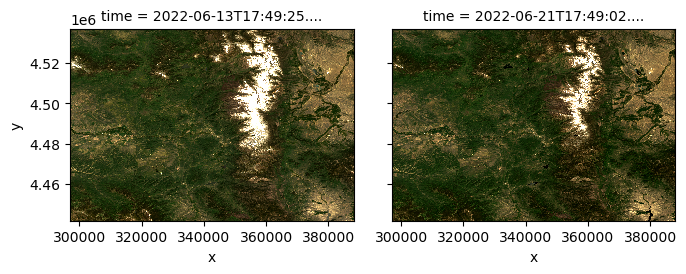

In [14]:
rgb_data = data.odc.to_rgba(vmin=1, vmax=15000, bands=["red", "green", "blue"])
rgb_data.plot.imshow(col="time", rgb="band", robust=True)

### Monthly composite using dask

In [21]:
# cluster = GatewayCluster()
# dask_client = cluster.get_client()
# cluster.adapt(minimum=4, maximum=24)
dask_client = dask.distributed.Client()
print(cluster.dashboard_link)

/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35625 instead
  warnings.warn(


http://127.0.0.1:35551/status


In [22]:
item_search = client.search(
    collections=[LANDSAT_COLLECTION],
    bbox=BBOX,
    datetime="2021",
    query=[f"eo:cloud_cover<=25"],
)
item_collection = planetary_computer.sign_item_collection(item_search.item_collection())
print(f"Found {len(item_collection)} items")

Found 65 items


In [23]:
data = odc.stac.load(
    item_collection,
    bands=["red", "green", "blue"],
    bbox=BBOX,
    resolution=100,
    groupby="solar_day",
    chunks={"x": 2048, "y": 2048},
)
data

<xarray.Dataset> Size: 245MB
Dimensions:      (y: 954, x: 910, time: 47)
Coordinates:
  * y            (y) float64 8kB 4.537e+06 4.537e+06 ... 4.442e+06 4.442e+06
  * x            (x) float64 7kB 2.971e+05 2.972e+05 ... 3.879e+05 3.88e+05
    spatial_ref  int32 4B 32613
  * time         (time) datetime64[ns] 376B 2021-01-01T17:49:32.270967 ... 20...
Data variables:
    red          (time, y, x) uint16 82MB dask.array<chunksize=(1, 954, 910), meta=np.ndarray>
    green        (time, y, x) uint16 82MB dask.array<chunksize=(1, 954, 910), meta=np.ndarray>
    blue         (time, y, x) uint16 82MB dask.array<chunksize=(1, 954, 910), meta=np.ndarray>

In [24]:
data.persist()

<xarray.Dataset> Size: 245MB
Dimensions:      (y: 954, x: 910, time: 47)
Coordinates:
  * y            (y) float64 8kB 4.537e+06 4.537e+06 ... 4.442e+06 4.442e+06
  * x            (x) float64 7kB 2.971e+05 2.972e+05 ... 3.879e+05 3.88e+05
    spatial_ref  int32 4B 32613
  * time         (time) datetime64[ns] 376B 2021-01-01T17:49:32.270967 ... 20...
Data variables:
    red          (time, y, x) uint16 82MB dask.array<chunksize=(1, 954, 910), meta=np.ndarray>
    green        (time, y, x) uint16 82MB dask.array<chunksize=(1, 954, 910), meta=np.ndarray>
    blue         (time, y, x) uint16 82MB dask.array<chunksize=(1, 954, 910), meta=np.ndarray>

/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [25]:
monthly_data = data.groupby("time.month").median().compute()
monthly_data

<xarray.Dataset> Size: 250MB
Dimensions:      (month: 12, y: 954, x: 910)
Coordinates:
  * y            (y) float64 8kB 4.537e+06 4.537e+06 ... 4.442e+06 4.442e+06
  * x            (x) float64 7kB 2.971e+05 2.972e+05 ... 3.879e+05 3.88e+05
    spatial_ref  int32 4B 32613
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    red          (month, y, x) float64 83MB 4.003e+04 3.911e+04 ... 2.762e+04
    green        (month, y, x) float64 83MB 3.785e+04 3.443e+04 ... 2.751e+04
    blue         (month, y, x) float64 83MB 3.694e+04 3.453e+04 ... 2.806e+04

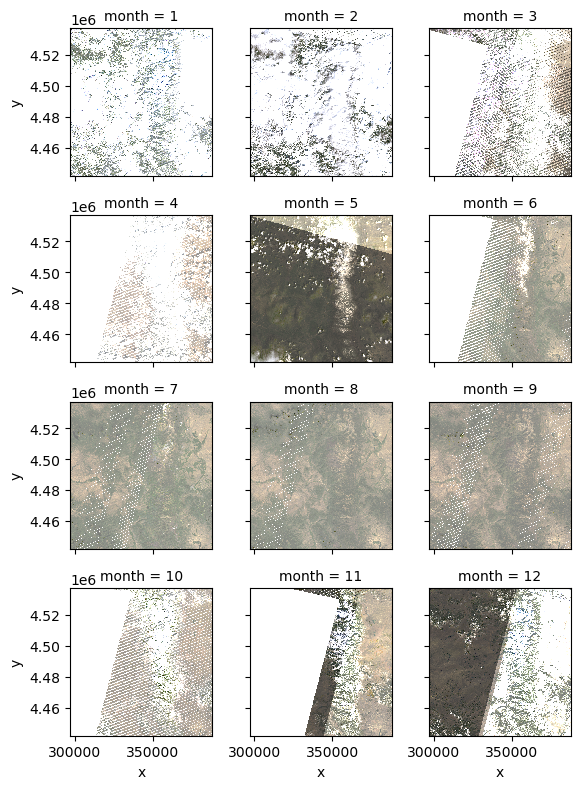

In [26]:
monthly_data_rgb = monthly_data.odc.to_rgba(vmin=1, vmax=15000, bands=["red", "green", "blue"])
monthly_data_rgb.plot.imshow(x="x", y="y", rgb="band", col="month", col_wrap=3, figsize=(6, 8))